# Подготовим данные

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Diplom/first_images.zip

In [ ]:
# Скачаем данные, собранные с Циана из Москвы и Санкт Петербурга
df_Moscow = pd.read_csv('/content/drive/MyDrive/Diplom/Moscow-data.csv')
df_SP = pd.read_csv('/content/drive/MyDrive/Diplom/SP-data.csv')

In [ ]:
# Объединим эти таблицы
df_new = pd.concat([df_Moscow, df_SP]).reset_index()
df_new = df_new.drop(columns = ['index', 'Unnamed: 0'])

torch.Size([3, 444, 640])


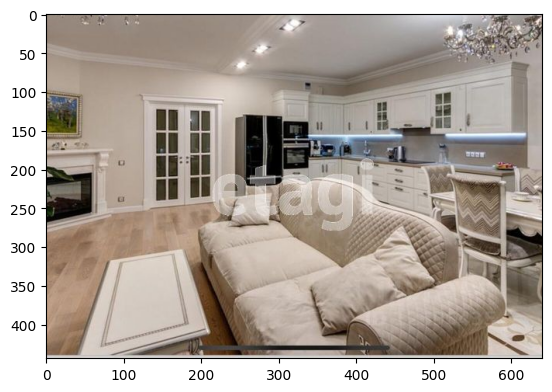

In [ ]:
# Посмотрим, как выглядят наши картинки
import matplotlib.pyplot as plt
img = torchvision.io.read_image('first_images/moscow_image_0002983.jpg') / 255
print(img.shape)
plt.imshow(img.permute(1, 2, 0), cmap='gray')

In [ ]:
df_new = df_new.fillna('')
df_new = df_new.drop(df_new[df_new['Repair_types_id'] == ''].index).reset_index().drop(columns=['index'])

In [ ]:
# Приведем наш таргет к типу int
df_new['Repair_types_id'] = df_new['Repair_types_id'].apply(int)
df_Moscow['Repair_types_id'] = df_Moscow['Repair_types_id'].apply(int)

In [ ]:
# Удалим все картинки, чей размер меньше 240*240, чтобы потом можно было сделать T.RandomCrop(240)
drop_list = []
for i in range(len(df_new)):
    try:
        img = torchvision.io.read_image(df_new.iloc[i]['im_dir']) / 255
        if img.shape[1] < 240 or img.shape[2] < 240:
            drop_list += [i]
            print(img.shape)
    except:
        drop_list += [i]

torch.Size([3, 218, 421])
torch.Size([3, 408, 230])
torch.Size([3, 207, 274])


In [ ]:
len(drop_list)

134

In [ ]:
df_new = df_new.drop(drop_list)

In [ ]:
# Создадим класс, который будет возвращать считанную картинку
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, transform=None):
        self.transform = transform
        self.num_elem = len(X)
        self.X = X
        self.target = y

    def __getitem__(self, idx):
        image = torchvision.io.read_image(self.X.iloc[idx]) / 255

        if (self.transform is not None):
            image = self.transform(image)
        if (self.target is not None):
            return image, self.target.iloc[idx]
        return image
    
    def __len__(self):
        return self.num_elem

In [ ]:
# Зададим аугументации, которые подходят для модели EfficientNet
import torchvision.transforms as T

train_transform = nn.Sequential(
    T.RandomCrop(240),
    T.ColorJitter(brightness=.1),
    # T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1)),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
)

test_transform = nn.Sequential(
    T.CenterCrop(240),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
)

In [ ]:
train_dataset = MyDataset(df_new['im_dir'], df_new['Repair_types_id'], transform=train_transform)

In [ ]:
drop_list = []
for i in range(len(train_dataset)):
    try:
        train_dataset[i][0]
    except:
        drop_list += [i]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
len(drop_list)

0

In [ ]:
df_new = df_new.drop(drop_list)

In [ ]:
# Разделим наш датасет на обучающую и тестовую выборку
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_new['im_dir'], df_new['Repair_types_id'], test_size=0.15, random_state=42, stratify = df_new['Repair_types_id'])

# Посмотрим точность предсказаний на каждом классе

In [ ]:
# model = net.load_state_dict(torch.load('./eff_net_model_86_48', map_location=torch.device('cpu')))
# model = torch.load('/content/drive/MyDrive/Diplom/eff_net_model_86_48', map_location ='cpu')
model = torch.load('./eff_net_model_82')

In [ ]:
dataset = MyDataset(df_new['im_dir'], df_new['Repair_types_id'], transform=train_transform)

batch_size=1
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.eval()

In [ ]:
from tqdm.notebook import tqdm
predictions = np.array([])
true_labels = np.array([])
for x_batch, y_batch in tqdm(dataset_loader):
    data = x_batch.to(device)
    target = y_batch.cpu().numpy()
    output = model(data)
    preds = np.argmax(nn.functional.softmax(output).cpu().detach().numpy(), 1)
    predictions = np.append(predictions, preds)
    true_labels = np.append(true_labels, target)

In [ ]:
df = pd.DataFrame(
    {
        'preds': predictions,
        'target': true_labels
    }
)

In [ ]:
df['is_true'] = df['target'] == df['preds']

In [ ]:
df

,preds,target,is_true
0,1.0,3.0,False
1,1.0,3.0,False
2,1.0,1.0,True
3,1.0,3.0,False
4,0.0,1.0,False
...,...,...,...
11222,1.0,1.0,True
11223,0.0,0.0,True
11224,0.0,0.0,True
11225,3.0,2.0,False


In [ ]:
df.groupby(by='target').mean()[['is_true']]

,is_true
target,
0.0,0.745982
1.0,0.643130
2.0,0.183394
3.0,0.612308


# Достанем эмбеддинги из Efficient Net


In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

In [ ]:
model

In [ ]:
model.classifier.linear2 = Identity()

In [ ]:
test_data = df_new
test_data['img_embed'] = None
test_data.shape

(11227, 17)

In [ ]:
test_data.sample()

,first_image_link,art_link,all_view_num,today_view_num,repair_type,date_string,price,images_links,room_num,parcing_date,region,im_dir,Repair_types_id,creature_date,display_days,avg_views,img_embed
10359,https://cdn-p.cian.site/images/23/633/861/1683...,https://spb.cian.ru/sale/flat/283579216/,394,1,Без ремонта,394 просмотра с даты создания объявления 11.02...,15800000,['https://cdn-p.cian.site/images/23/633/861/16...,4,28.04.2023,2,first_images/sp_image_0004709.jpg,0,11.02.2023,76,5.184211,None


In [ ]:
from tqdm.notebook import tqdm
predictions = np.array([])
true_labels = np.array([])
i = 0
for x_batch, y_batch in tqdm(dataset_loader):
    data = x_batch.to(device)
    # target = y_batch.cpu().numpy()
    output = model(data)
    test_data['img_embed'].iloc[i] = output.cpu().detach().numpy()
    i += 1
    # preds = np.argmax(nn.functional.softmax(output).cpu().detach().numpy(), 1)
    # predictions = np.append(predictions, preds)
    # true_labels = np.append(true_labels, target)


  0%|          | 0/11227 [00:00<?, ?it/s]

In [ ]:
test_data

In [ ]:
# df3 = pd.DataFrame(test_data['img_embed'].tolist())
df3 = pd.DataFrame()
for i in range(len(test_data)):
    df3 = pd.concat([df3, pd.DataFrame(test_data['img_embed'].iloc[i].tolist())])

In [ ]:
df3.shape

(11227, 256)

In [ ]:
test_data = test_data.reset_index()

In [ ]:
test_data['im_dir']

0        first_images/moscow_image_0000000.jpg
1        first_images/moscow_image_0000001.jpg
2        first_images/moscow_image_0000002.jpg
3        first_images/moscow_image_0000003.jpg
4        first_images/moscow_image_0000004.jpg
                         ...                  
11222        first_images/sp_image_0005716.jpg
11223        first_images/sp_image_0005717.jpg
11224        first_images/sp_image_0005718.jpg
11225        first_images/sp_image_0005719.jpg
11226        first_images/sp_image_0005720.jpg
Name: im_dir, Length: 11227, dtype: object

In [ ]:
df3 = df3.reset_index().drop(columns = ['index'])

In [ ]:
df3['avg_views'] = test_data['avg_views']
df3['price'] = test_data['price']
df3['room_num'] = test_data['room_num']
df3['region'] = test_data['region']
df3['repair_type'] = test_data['repair_type']
df3['im_dir'] = test_data['im_dir']

In [ ]:
df3.to_csv('Moscow_and_SP_embeds_after_classification.csv')

# Запустим кластеризацию на полученных эмбеддингах

In [ ]:
from sklearn.cluster import KMeans
num = 4
kmeans = KMeans(n_clusters=num)
kmeans.fit_predict(df3.iloc[:, range(0, 1280)])

In [ ]:
labels = kmeans.labels_

In [ ]:
for i in range(num):
    print('NUM ELEMS IN CLASS:', (labels == i).sum(), ' MEAN:', df3[labels == i]['avg_views'].mean(), df3.loc[labels == i].groupby(by=["repair_type"]).count()[0])

NUM ELEMS IN CLASS: 336  MEAN: 25.14833986470158 repair_type
Без ремонта       11
Дизайнерский     238
Евроремонт        64
Косметический     23
Name: 0, dtype: int64
NUM ELEMS IN CLASS: 224  MEAN: 19.25473997133497 repair_type
Без ремонта      141
Дизайнерский      25
Евроремонт        24
Косметический     34
Name: 0, dtype: int64
NUM ELEMS IN CLASS: 69  MEAN: 8.909848103158282 repair_type
Без ремонта      66
Дизайнерский      2
Косметический     1
Name: 0, dtype: int64
NUM ELEMS IN CLASS: 240  MEAN: 27.09161322691778 repair_type
Без ремонта       12
Дизайнерский      32
Евроремонт        81
Косметический    115
Name: 0, dtype: int64


In [ ]:
df3['price_type'] = ''

<Axes: xlabel='price', ylabel='Count'>

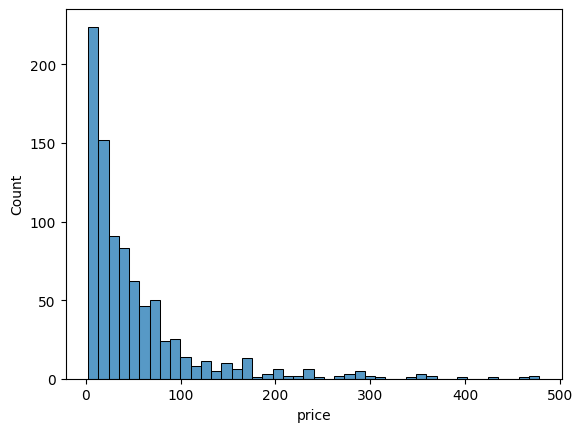

In [ ]:
# Посмотрим на распределение объявлений по цене
from seaborn import histplot
histplot(df3['price'] / 1000000)